<a href="https://colab.research.google.com/github/BalramAgnihotri123/Machine-Learning-And-Deep-Learning-HandsOn/blob/main/(YOLO)Car_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!jar xvf drive/MyDrive/10k.zip
!jar xvf drive/MyDrive/labels.zip

Streaming output truncated to the last 5000 lines.
 inflated: 10k/train/3d187d59-48023a43.jpg
 inflated: 10k/train/3d1a6305-3980e3bc.jpg
 inflated: 10k/train/3d2c1ef5-fdc7bea5.jpg
 inflated: 10k/train/3d3117f0-9365aac0.jpg
 inflated: 10k/train/3d317eb1-4a9f2f5c.jpg
 inflated: 10k/train/3d31c23f-bb0e2813.jpg
 inflated: 10k/train/3d31d9a7-2fa8d37a.jpg
 inflated: 10k/train/3d3a3638-268c8d7f.jpg
 inflated: 10k/train/3d3a3638-d2cf7766.jpg
 inflated: 10k/train/3d3f2fa6-666e1cf1.jpg
 inflated: 10k/train/3d411c3d-1324dab3.jpg
 inflated: 10k/train/3d411c3d-a9202cf2.jpg
 inflated: 10k/train/3d507efc-2d6c0219.jpg
 inflated: 10k/train/3d50b2fd-031cce4f.jpg
 inflated: 10k/train/3d5169ab-8ec93ab4.jpg
 inflated: 10k/train/3d62a6ae-557b2813.jpg
 inflated: 10k/train/3d72f33d-629e09ef.jpg
 inflated: 10k/train/3d74dd6a-12517fd5.jpg
 inflated: 10k/train/3d7be789-6e1cdeb5.jpg
 inflated: 10k/train/3d80b59b-589b6b56.jpg
 inflated: 10k/train/3d84a8de-b382a1a1.jpg
 inflated: 10k/train/3d860ec4-d7102e99.jpg
 in


## Importing relevent Liabraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import torchvision
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torchvision import models
import cv2
import torch.nn.functional as F
from PIL import Image
import os 
from collections import Counter
from pathlib import Path
import zipfile
import requests
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import xml.etree.ElementTree as ET
from torch import optim

In [ ]:
image_folder = Path("10k")
all_labels_folder = Path("labels")

In [ ]:
images = list(image_folder.glob("*/*.jpg"))
all_labels_path = list(all_labels_folder.glob("*/"))

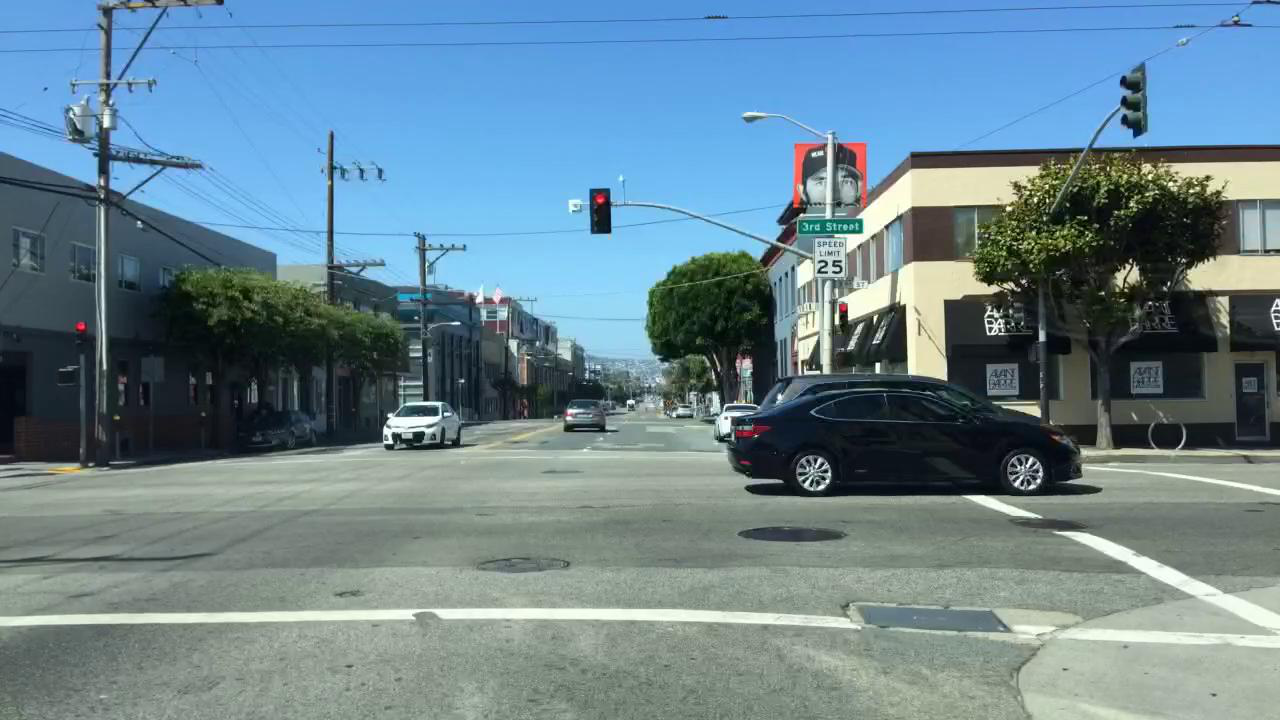

In [ ]:
import random
random_image_path = random.choice(images)
Image.open(random_image_path)

**Extracting relevent data from 10K images**

`1. Lables for all the images are not available.`

`2. extracting the images whose labels are available with Bounding Boxes.` 

`3. Processing the data to prepare for model training.`

In [ ]:
# importing the module
import json
 
# Opening JSON file
with open('labels/bdd100k_labels_images_val.json') as json_file:
    labels = json.load(json_file)
with open('labels/bdd100k_labels_images_train.json') as json_file:
    label2 = json.load(json_file)

In [ ]:
for i in label2:
  labels.append(i)

In [ ]:
## matching all 70k+ labels with 10K images to find the correct images with labels
from tqdm import tqdm  ## For Progress bar
new_labels=[] 
new_images =[]
for i in tqdm(range(len(labels))):
  for j in range(len(images)):
    if f"{images[j].stem}.jpg" == str(labels[i].get("name")):
      new_labels.append(labels[i])
      new_images.append(images[j])
    else:
      pass

100%|██████████| 79863/79863 [16:06<00:00, 82.65it/s]


In [ ]:
## Assigning image name( path name) to all the respective bounding boxes
labels_with_bbox = []
a=0
for j in tqdm(range(len(new_labels))):
  for i in range(len(new_labels[j].get("labels"))):

    #if new_labels[j].get("labels")[i].get("category")=="car":
      labels_with_bbox.append(new_labels[j].get("labels")[i])
      labels_with_bbox[a]["Name"] = new_images[j]
      a+=1
    #else:
      #pass

100%|██████████| 3426/3426 [00:00<00:00, 57343.64it/s]


In [ ]:
## Getting rid of unnessary featuers in the lables list of dictionaries
items_not_needed =['attributes','id','manualShape','manualAttributes']
for i in labels_with_bbox:
  for j in items_not_needed:
    i.pop(j, None)

### Plotting an image with a bounding box

In [ ]:
pil_image =Image.open(labels_with_bbox[0].get("Name"))
bbox =labels_with_bbox[0].get("box2d")
x1,y1,x2,y2 = bbox["x1"],bbox["y1"],bbox["x2"],bbox["y2"]
box=[]
box.append(x1)
box.append(y1)
box.append(x2)
box.append(y2)

def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

img = read_image(labels_with_bbox[0].get("Name"))



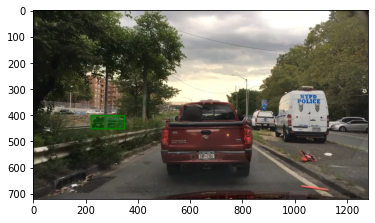

In [ ]:
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import ToTensor
transform = ToTensor()
tensor_image = transform(pil_image)
tensor_image = torchvision.transforms.functional.convert_image_dtype(tensor_image,dtype = torch.uint8)
bbox = torch.tensor(box)
tensor_image.shape

boxed_image = draw_bounding_boxes(tensor_image,bbox.unsqueeze(0), width=5,colors="green", fill=True)
img = torchvision.transforms.ToPILImage()(boxed_image)
  
# display output
plt.imshow(img)

### Putting all the data in a data frame so that its easily accessable

In [ ]:
images_path = []
for i in range(len(labels_with_bbox)):
  images_path.append(labels_with_bbox[i].get("Name"))

labels = []
for i in range(len(labels_with_bbox)):
  labels.append(labels_with_bbox[i].get("category"))

box2d =[]
for i in range(len(labels_with_bbox)):
  box2d.append(labels_with_bbox[i].get("box2d"))

df = pd.DataFrame()
df['image_path'] = images_path
df['labels'] = labels
df['box2d'] = box2d
df_test = df["box2d"].isna()
df_train = df[~df["box2d"].isna()]
df_train = df_train.reset_index()
df_train = df_train.sample(n=10000, replace=True, random_state=42)
df_train = df_train.reset_index()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   level_0     10000 non-null  int64 
 1   index       10000 non-null  int64 
 2   image_path  10000 non-null  object
 3   labels      10000 non-null  object
 4   box2d       10000 non-null  object
dtypes: int64(2), object(3)
memory usage: 390.8+ KB


In [ ]:
x1,y1,x2,y2 = [],[],[],[]
for i in range(len(df_train)):
  bbox = dict(df_train.box2d[i]).values()
  bbox = list(bbox)
  x1.append(bbox[0])
  y1.append(bbox[1])
  x2.append(bbox[2])
  y2.append(bbox[3])
df_train["x1"]=x1
df_train["y1"]=y1
df_train["x2"]=x2
df_train["y2"]=y2
df_train.head()

,level_0,index,image_path,labels,box2d,x1,y1,x2,y2
0,15795,23105,10k/train/138df911-71d9812a.jpg,car,"{'x1': 12.651043, 'y1': 283.416728, 'x2': 61.5...",12.651043,283.416728,61.550409,300.381815
1,860,1208,10k/train/b3f2fee7-1482dee6.jpg,car,"{'x1': 640.002372, 'y1': 335.425868, 'x2': 655...",640.002372,335.425868,655.916738,352.564416
2,54886,81523,10k/train/8b1e7043-f83740f0.jpg,traffic sign,"{'x1': 507.711424, 'y1': 224.164985, 'x2': 519...",507.711424,224.164985,519.587716,239.010349
3,6265,9054,10k/train/c1ba5ee6-81459f71.jpg,truck,"{'x1': 607.80192, 'y1': 432.951796, 'x2': 617....",607.801920,432.951796,617.686663,473.589076
4,37194,54836,10k/train/54a5fadd-6023e1aa.jpg,person,"{'x1': 145.356926, 'y1': 234.899833, 'x2': 177...",145.356926,234.899833,177.419404,309.149782


In [ ]:
df_train.columns
df_train = df_train[['image_path', 'labels', 'x1', 'y1', 'x2', 'y2']]

In [ ]:
## Turning categorical labels into discrete variables.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df_train["labels"] = le.fit_transform(df_train["labels"])
df_train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,image_path,labels,x1,y1,x2,y2
0,10k/train/138df911-71d9812a.jpg,2,12.651043,283.416728,61.550409,300.381815
1,10k/train/b3f2fee7-1482dee6.jpg,2,640.002372,335.425868,655.916738,352.564416
2,10k/train/8b1e7043-f83740f0.jpg,7,507.711424,224.164985,519.587716,239.010349
3,10k/train/c1ba5ee6-81459f71.jpg,9,607.801920,432.951796,617.686663,473.589076
4,10k/train/54a5fadd-6023e1aa.jpg,4,145.356926,234.899833,177.419404,309.149782


In [ ]:
def make_bbox(df):

  """
  Returns a Bounding Box in a array form
  """
  bbox = []
  for i,row in df.iterrows():
    array = np.array([row["x1"],row["y1"],row["x2"],row["y2"]])
    bbox.append(array)
  return bbox

def normalize_bbox(df:pd.DataFrame): ## dataframe of bboxs
  """
  returns a normalized bounding box
  """
  bbox = make_bbox(df)
  for box in bbox:
    box[0]/=1280
    box[1]/=720
    box[2]/=1280
    box[3]/=720
  return bbox

new_df = df_train.copy()

new_df["bbox"] = make_bbox(df_train.iloc[:,2:])
df_train["normalize_bbox"] = normalize_bbox(df_train.iloc[:,2:])

## Creating a Model

In [ ]:
X = df_train.drop("labels",axis =1)
y = df_train['labels']

In [ ]:
## Dividing the dataset into training and testing data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state =42,test_size = 0.2,shuffle=False)

#### Creating a Transformer

`Converts the image into tensor and normalization.`

In [ ]:
train_transformer = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])
test_transformer = transforms.Compose([
      transforms.ToTensor()
  ])

In [ ]:
train_transformer(Image.open(X.image_path[0]))

tensor([[[-0.4667, -0.4902, -0.5373,  ...,  0.9451,  0.9451,  0.9451],
         [-0.4902, -0.5059, -0.5451,  ...,  0.9451,  0.9451,  0.9451],
         [-0.5137, -0.5373, -0.5529,  ...,  0.9451,  0.9451,  0.9451],
         ...,
         [-0.8510, -0.8588, -0.8745,  ..., -0.3804, -0.3490, -0.3255],
         [-0.8824, -0.8824, -0.8824,  ..., -0.3255, -0.3255, -0.3333],
         [-0.9294, -0.9216, -0.8980,  ..., -0.2549, -0.3020, -0.3333]],

        [[-0.2863, -0.3098, -0.3647,  ...,  1.0000,  1.0000,  1.0000],
         [-0.3176, -0.3333, -0.3569,  ...,  1.0000,  1.0000,  1.0000],
         [-0.3412, -0.3569, -0.3725,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [-0.6549, -0.6627, -0.6863,  ..., -0.3569, -0.3255, -0.3020],
         [-0.7020, -0.7020, -0.7020,  ..., -0.2784, -0.2784, -0.2863],
         [-0.7490, -0.7412, -0.7176,  ..., -0.2078, -0.2549, -0.2863]],

        [[-0.4118, -0.4353, -0.4667,  ...,  0.9843,  0.9843,  0.9843],
         [-0.4196, -0.4353, -0.4588,  ...,  0

### Custom Dataset

`A Custom Dataset that returns a tensor image, respective label and respective bounding box. `

In [ ]:
class ImageDataset(Dataset):
  def __init__(self,
               image_paths,
               labels,
               bbox,
               transformer
               ):
    self.paths = image_paths
    self.labels = y
    self.bbox = bbox
    self.transformer=transformer

  def __len__(self):
    return len(self.paths)

  def __getitem__(self,idx):
    path = self.paths[idx]
    pil_img = Image.open(path)
    img_tensor = self.transformer(pil_image)
    label = self.labels[idx]
    bbox = torch.from_numpy(self.bbox[idx])
    
    return img_tensor, label, bbox

In [ ]:
train_ds = ImageDataset(X_train['image_path'].values,
                        labels=y_train.values,
                        bbox=X_train.normalize_bbox.values,
                        transformer = train_transformer)


test_ds = ImageDataset(X_test['image_path'].values,
                       labels=y_test.values,
                       bbox=X_test.normalize_bbox.values,
                       transformer = test_transformer)

In [ ]:
### putting the data into a Dataloader in order to load the data into small chunks
BATCH_SIZE = 8
train_dataloader = DataLoader(train_ds, 
                      batch_size=BATCH_SIZE, 
                      shuffle=True)
test_dataloader = DataLoader(test_ds, 
                      batch_size=BATCH_SIZE) 

#### Architecture of the Model

`Not using state of the model Object detecion model like yolo's and coco's due to lack of computational efficiency.`

`Instead I used resnet's first 8 Convolutional blocks and applying the L1 loss function on bounding boxs in training loop.`



In [ ]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()

        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]

        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        
        self.classifier = nn.Sequential(nn.Linear(512, 10))

        self.bb = nn.Sequential(nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [ ]:
model = BB_model()
model.to("cuda")

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

BB_model(
  (features1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [ ]:
model

BB_model(
  (features1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [ ]:
def train_epocs(model, optimizer, train_dataloader,test_dataloader, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in tqdm(train_dataloader):
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)

            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()

            loss = loss_class + loss_bb/C

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, test_dataloader, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total

In [ ]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr


In [ ]:
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

train_epocs(model,
            optimizer,
            train_dataloader,
            test_dataloader)


100%|██████████| 2000/2000 [14:24<00:00,  2.31it/s]


train_loss 1.394 val_loss 1.809 val_acc 0.532


100%|██████████| 2000/2000 [14:13<00:00,  2.34it/s]


train_loss 1.369 val_loss 2.121 val_acc 0.532


100%|██████████| 2000/2000 [14:11<00:00,  2.35it/s]


train_loss 1.363 val_loss 2.988 val_acc 0.532


1.3634127815216779

In [ ]:
update_optimizer(optimizer, 0.001)
train_epocs(model, optimizer, train_dataloader, test_dataloader, epochs=5)

(<matplotlib.image.AxesImage at 0x7fbe65390510>, 'car', 2)

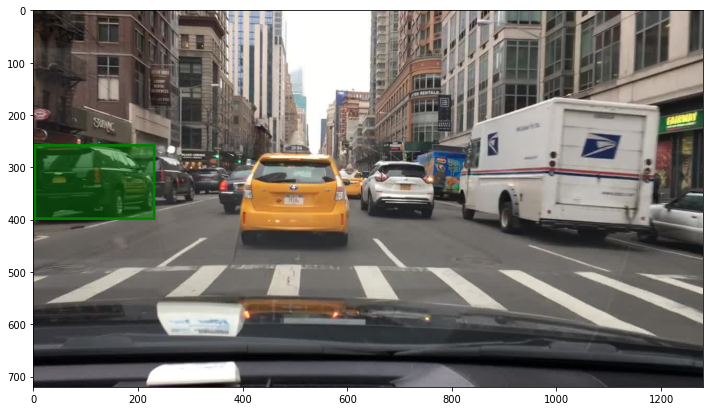

In [171]:
def detransform_bbox(bbox):
  
  """
  returns a bbox after detransforming its coordinates to normal dimensions
  """
  
  bb = [0,0,0,0]
  bb[0] = bbox[0].to("cpu")[0].item()*1280*1.6
  bb[1]=bbox[0].to("cpu")[1].item()*720*0.9
  bb[2]=bbox[0].to("cpu")[2].item()*1280*1.6
  bb[3]=bbox[0].to("cpu")[3].item()*720*0.9
  return bb

pil_image =Image.open(labels_with_bbox[40000].get("Name"))
bbox =labels_with_bbox[40000].get("box2d")
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import ToTensor
tensor_image = test_transformer(pil_image)
tensor_image.shape
y_cls,bb = model(tensor_image.cuda().unsqueeze(0))
actual_class = y_cls.argmax(dim=1).item()
actual_class =le.classes_[actual_class]
bb = detransform_bbox(bb)
bb = torch.tensor(bb)
tensor_image = torchvision.transforms.functional.convert_image_dtype(tensor_image,dtype = torch.uint8)
boxedimage = draw_bounding_boxes(tensor_image,bb.unsqueeze(0), width=5,colors="green", fill=True)
img = torchvision.transforms.ToPILImage()(boxed_image)
plt.figure(figsize=(12,12))
# display output
plt.imshow(img),labels_with_bbox[40000].get('category'),y_cls.argmax(dim=1).item()